In [1]:
import tensorflow as tf
gpu_devices=tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device,True)

2023-03-07 21:31:56.526333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 21:31:59.076276: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-07 21:31:59.076606: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-07 21:31:59.076613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:
%env SM_FRAMEWORK=tf.keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import nibabel as nib
from PIL import Image
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
import cv2
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
import random
seed =0
random.seed(seed) 
tf.random.set_seed(seed)
np.random.seed(seed)
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [4]:
import joblib as jlb
transfer_unmask,transfer_mask=jlb.load("transfer-unmask-mask.data")

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(transfer_unmask,transfer_mask,test_size=0.2,random_state=0,shuffle=True)

In [6]:
def downsample(filters, size, shape, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer='he_normal'))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())

    return result

def upsample(filters, size, shape, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,padding='same',
                                    kernel_initializer='he_normal'))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.2))

    result.add(tf.keras.layers.ReLU())

    return result

In [7]:
OUTPUT_CHANNELS = 1
def buildUNet():
    inputs = tf.keras.layers.Input(shape=[512,512,1])
    down_stack = [
        downsample(64, 3, (None, 512, 512,1), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 3, (None, 256, 256, 64)), # (bs, 128, 128, 128)
        downsample(128, 3, (None, 128, 128, 128)), # (bs, 64, 64, 128)
        downsample(256, 3, (None, 64, 64, 128)),
        downsample(256, 3, (None, 32, 32, 256)), # (bs, 16, 16, 512)
        downsample(512, 3, (None, 16, 16, 256)), # (bs, 8, 8, 512)
        downsample(512, 3, (None, 8, 8, 512)), # (bs, 4, 4, 512)
        downsample(512, 3, (None, 4, 4, 512)), # (bs, 2, 2, 512)
        downsample(512, 3, (None, 2, 2, 512)), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 3, (None, 1, 1, 512), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 3, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 3, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 3, (None, 8, 8, 1024)), # (bs, 16, 16, 1024)
        upsample(256, 3, (None, 16, 16, 768)), # (bs, 32, 32, 512)
        upsample(256, 3, (None, 32, 32, 512)), # (bs, 64, 64, 256)
        upsample(128, 3, (None, 64, 64, 384)), # (bs, 128, 128, 128)
        upsample(128, 3, (None, 128, 128, 256)),
        upsample(64, 3, (None, 256, 256, 96)),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
#     initializer='he_normal'
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,strides=2,padding='same',
                                           kernel_initializer=initializer,
                                           activation='sigmoid') # (bs, 256, 256, 1)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train, y_train, 16)
test_gen = DataGenerator(x_test, y_test, 16)



In [ ]:
model = buildUNet()
model.compile(optimizer = 'adam', loss =  'binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen,
                    epochs=200,
                    validation_data=test_gen,
                    verbose=2)

In [ ]:
model.save('model3-7-300ep.hdf5')

In [8]:
# transfer
model = buildUNet()
model.compile(optimizer = 'adam', loss =  'binary_crossentropy', metrics=['accuracy'])
model.load_weights('model3-7-300ep.hdf5')

2023-03-07 21:34:40.499043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 21:34:41.671558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38159 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


In [9]:
y_pred = model.predict(x_test[0:1000])

y_pred_th = y_pred > 0.5
intersection = np.logical_and(y_test[0:1000],y_pred_th)
union = np.logical_or(y_test[0:1000],y_pred_th)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is:",iou_score) 

2023-03-07 21:34:47.409922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-03-07 21:34:49.504632: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


32/32 [==============================] - 10s 81ms/step
IoU score is: 0.9805184948352126


In [11]:
pred=y_pred_th
yte=y_test[0:1000]

[[22911759, 249835], [205389, 238777017]]


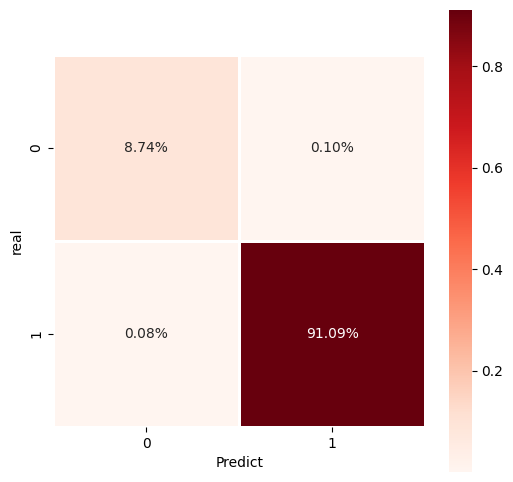

presicion:  0.9911152967485436
recall:  0.9892133935168711
F1-Score:  0.9901634318409087
Pixel_accuracy:  0.9982634582519532
dice:  0.9901634318409087
IoU:  0.9805184948352126


In [15]:
import seaborn as sns

FP = len(np.where(pred - yte == 1.)[0])
FN = len(np.where(pred - yte == -1.)[0])
TP = len(np.where(pred + yte == 2.)[0])
TN = len(np.where(pred + yte == 0.)[0])
cmat = [[TP,FN],[FP,TN]]
print(cmat)
plt.figure(figsize=(6,6))
sns.heatmap(cmat/np.sum(cmat),cmap="Reds",annot=True,fmt='.2%',square=1,linewidth=2.)
plt.xlabel('Predict')
plt.ylabel('real')
plt.show()
presicion = TP / (TP+FP)
recall = TP / (TP+FN)
F1 = 2 * (presicion*recall)/(presicion+recall)
Pixel_accuracy=(TP+TN)/(TP+TN+FP+FN)
dice=(2*TP)/(2*TP+FP+FN)
iou=TP/(TP+FP+FN)

print("presicion: ",presicion)
print("recall: ",recall)
print("F1-Score: ",F1)
print("Pixel_accuracy: ",Pixel_accuracy)
print("dice: ",dice)
print("IoU: ",iou)

In [10]:
def Plot_ACC_LOSS(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss,'y',label='Traning loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title('Traning and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
Plot_ACC_LOSS(all_history[i])

In [ ]:
for i in range(y_test.shape[0]):
    img = y_test[i]
    print(i)
    plt.imshow(img)
    plt.show()